In [209]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
import spacy
import collections
import numpy as np
from spacy.en import English
import string
import unicodedata
import gensim
import re
from collections import Counter
from itertools import chain
from scipy.spatial import distance
import spacy
from collections import Counter

nlp = spacy.load('en')
parser = English()
sqd_data = pd.read_json("/data/data_repo/train-v1.1.json")

In [25]:
from plotly.offline import plot
from plotly.graph_objs import *

In [2]:
sqd_data.head()
print(len(sqd_data))

442


In [3]:
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format('/home/aleena/Downloads/GoogleNews-vectors-negative300.3.bin', binary=True)


In [4]:
stopword = stopwords.words('english')
qtntype_list = ['How', 'What', 'When', 'Why', 'Which', 'Who','Whom', 'Where']
pun_list = list(string.punctuation)
delelements_list = stopword + qtntype_list + pun_list

In [5]:
qtntype_list

['How', 'What', 'When', 'Why', 'Which', 'Who', 'Whom', 'Where']

In [6]:
row_list = ['How many','How much','What','When','Where','Who', 'Which','Whom','PERSON',
          'NORP', 'FAC','LOC','PRODUCT', 'EVENT','WORK_OF_ART','LANGUAGE' ,'DATE' ,
          'TIME' ,'PERCENT' ,'MONEY' ,'ORDINAL','CARDINAL','GPE', 'ORG']


column_list = ['PERSON','NORP', 'FAC','LOC','PRODUCT', 'EVENT','WORK_OF_ART','LANGUAGE' ,'DATE' ,
               'TIME' ,'PERCENT' ,'MONEY' ,'ORDINAL','CARDINAL','GPE','ORG']

In [7]:
co_occ_matrix = np.zeros((len(row_list), len(column_list)), dtype = int)
co_occ_matrix

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0,

### Co-occurence matrix on 442 paragraphs

In [8]:
def replace_all(repls, str):
   # return re.sub('|'.join(repls.keys()), lambda k: repls[k.group(0)], str)                                    
   return re.sub('|'.join(re.escape(key) for key in repls.keys()),
                 lambda k: repls[k.group(0)], str)

In [9]:
def preprocess_question(para_question):
    question_list = []
    for i in range(len(para_question)):
        l1 = para_question[i]['question']
        l1 = unicodedata.normalize('NFKD', l1).encode('ascii','ignore').decode('utf-8')
        question_list.append(l1)
    
    #Appropriate question type replacement
    Question_list = []
    for i in range(len(question_list)):
        Question_list.append(replace_all({"how": "How", "when": "When","what": "What","whom": "Whom","which": "Which", "where": "Where", "who":"Who" }, question_list[i]))
        
    return Question_list   

In [10]:
def preprocess_text(para_context):

    context = unicodedata.normalize('NFKD', para_context).encode('ascii','ignore').decode('utf-8')
    #print(context)
    #sentence_tokeniztion
    senttokenized_context = sent_tokenize(context)
    sentencelist = []
    for sent_token in senttokenized_context:
        sentencelist.append(sent_token) 
    
    sentence_list = []
    lemmatizer = WordNetLemmatizer()


    for i in sentencelist:
        words = nltk.word_tokenize(i)
        words = ([x.lower() for x in words])
        words = ([x for x in words if x not in delelements_list])
        words = [lemmatizer.lemmatize(x) for x in words]
        words = [[s.encode('ascii').decode('utf-8') for s in words]]
        sentence_list.append(words)
    return sentencelist, sentence_list

In [11]:
def question_type_extractor(question_mapping):
    Question_mapping = []
    for i in range(len(question_mapping)):
        if question_mapping[i] != 'How many' and question_mapping[i] != 'How much':
            Question_mapping.append(question_mapping[i].split()[0])
        else:
             Question_mapping.append(question_mapping[i])
    return Question_mapping

In [12]:
def wmd_que_ans_pair(que_list, sen_list):
    wmd_matrix = np.zeros([len(que_list),len(sen_list)]) 
    for i in range(len(que_list)):
        for j in range(len(sen_list)):
            wmd_matrix[i,j] =  word2vec_model.wmdistance(que_list[i],sen_list[j])  
    wmd_df = pd.DataFrame(wmd_matrix)
    wmd_df['sentence'] = wmd_df.T.idxmin()
    wmd_df['qnno'] = wmd_df.index
    que_no_ans_sen_no = []
    for i in range(len(wmd_df)):
        que_no_ans_sen_no.append([wmd_df['qnno'][i], wmd_df['sentence'][i]])
    qn_sentence = []
    for i in range(len(que_no_ans_sen_no)):
        if que_no_ans_sen_no[i][0] == que_list.index(que_list[i]):
            qn_sentence.append(que_list[i])
    an_sentence = []
    for i in range(len(que_no_ans_sen_no)):
        for j in range(len(sen_list)):
            if que_no_ans_sen_no[i][1] == sen_list.index(sen_list[j]):
                an_sentence.append(sen_list[j]) 
    return qn_sentence, an_sentence

In [13]:
def que_ner_ans_ner(que_sentence, ans_sentence):
    ans_sentence_mapping = []
    for i in range(len(ans_sentence)):
        doc_ans = nlp(ans_sentence[i])
        for ent in doc_ans.ents:
            ans_sentence_mapping.append([i,ent.label_])

    que_sentence_mapping = []
    for i in range(len(que_sentence)):
        doc_que = nlp(que_sentence[i])
        for ent in doc_que.ents:
            que_sentence_mapping.append([i,ent.label_])
    return que_sentence_mapping, ans_sentence_mapping

In [14]:
def que_df_ans_df(que_sen_map, ans_sen_map):
    qno_anstag_df = pd.DataFrame(ans_sen_map,columns = ['QuestionNo','AnswerTag'])
    qno_quetag_df = pd.DataFrame(que_sen_map, columns = ['QuestionNo', 'QuestionTag'])
    return qno_quetag_df, qno_anstag_df 

In [15]:
def que_ans_combo_(questionword, answerword):
    ques_ans_combo = []
    for i in range(len(questionword)):
        for j in range(len(answerword)):
            ques_ans_combo.append([questionword[i],answerword[j]])
    return(ques_ans_combo)

In [16]:
def question_type(process_que_list):
    question_mapping = [] 
    for i in range(len(process_que_list)):
        l2 = nltk.word_tokenize(process_que_list[i])
        #print(len(l2))
        #print(l2)
        missed = l2[-1]        
        if missed == '?':
            for j in range(len(l2)):


                if l2[j] in qtntype_list:
                    combine_list = l2[j]+" "+l2[j+1]
                    question_mapping.append(combine_list)

        else:

             for k in range(len(l2)):#8

                if k < len(l2)-1:  #7        

                    if l2[k] in qtntype_list:
                        combine_list = l2[k]+" "+l2[k+1]
                        question_mapping.append(combine_list) 
                else:

                        if l2[k] in qtntype_list:
                            combine_list = l2[k]+" "+'abc'
                            question_mapping.append(combine_list) 
    return question_mapping

### On to the execution part

In [17]:
for i in range(len(sqd_data)):
    print(i)
    paragraph_pointer = sqd_data.data[i]['paragraphs'] 

    #print(i, " ", len(paragraph_pointer))
    for j in range(len(paragraph_pointer)):#no of paragraphs in a row of the df
        
        processed_sen_list, process_sen_tokenized_list = preprocess_text(paragraph_pointer[j]['context']) 
        processed_que_list = preprocess_question(paragraph_pointer[j]['qas'])
        question_mapping = question_type(processed_que_list)
        que_type_extract = question_type_extractor(question_mapping)
        
        que_sen, ans_sen = wmd_que_ans_pair(processed_que_list, processed_sen_list)

        que_sen_map, ans_sen_map = que_ner_ans_ner(que_sen, ans_sen)
        que_no_quetag_df, que_no_anstag_df = que_df_ans_df(que_sen_map, ans_sen_map)
        
        for i in range(len(que_type_extract)):

            question_words = que_no_quetag_df[que_no_quetag_df['QuestionNo']== i]['QuestionTag'].tolist() + [que_type_extract[i]]
            ans_words = que_no_anstag_df[que_no_anstag_df['QuestionNo']==i]['AnswerTag'].tolist()
            combo = que_ans_combo_(question_words, ans_words)
            
            for i, v1 in enumerate(row_list):
                for j, v2 in enumerate(column_list):
                    for k in combo:
                        if [v1, v2] == k:
                            co_occ_matrix[i, j]+=1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

### Generating Heatmap for the co-occurence matrix

In [19]:
co_occ_matrix_df = pd.DataFrame(co_occ_matrix, index = row_list, columns= column_list)
co_occ_matrix_df

,PERSON,NORP,FAC,LOC,PRODUCT,EVENT,WORK_OF_ART,LANGUAGE,DATE,TIME,PERCENT,MONEY,ORDINAL,CARDINAL,GPE,ORG
How many,1595,1496,165,422,30,155,174,52,2719,112,330,233,488,5361,3512,3522
How much,319,269,20,84,14,26,18,18,729,24,336,352,81,528,650,684
What,20672,15822,1462,4499,458,1298,2082,822,19312,643,2131,854,3984,12788,29030,32959
When,3168,2244,182,580,60,253,295,97,4704,98,53,91,790,1670,4273,4512
Where,2018,1263,304,577,36,111,152,46,1428,33,38,36,397,968,3536,3078
Who,8370,3539,225,703,92,292,530,101,4188,93,94,105,999,1975,5472,7098
Which,3886,2278,339,821,88,208,354,107,2771,80,149,127,684,1737,4890,5017
Whom,297,131,10,24,1,13,14,5,150,0,4,4,40,61,216,261
PERSON,19801,4338,498,1145,156,399,1082,238,7442,212,200,238,1420,3803,8492,9829
NORP,4714,12553,217,1346,115,343,424,405,4348,93,709,134,855,2854,8436,6013


In [20]:
co_occ_matrix_df['Tags'] = co_occ_matrix_df.index

In [21]:
melt_co_occ_matrix_df = pd.melt(co_occ_matrix_df,id_vars = ['Tags'])
melt_co_occ_matrix_df.head()


import plotly.plotly as py
import plotly.graph_objs as go

trace = go.Heatmap(z=melt_co_occ_matrix_df['value'],
                  x=melt_co_occ_matrix_df['Tags'] ,
                  y=melt_co_occ_matrix_df['variable'])
data=[trace]
py.iplot(data)

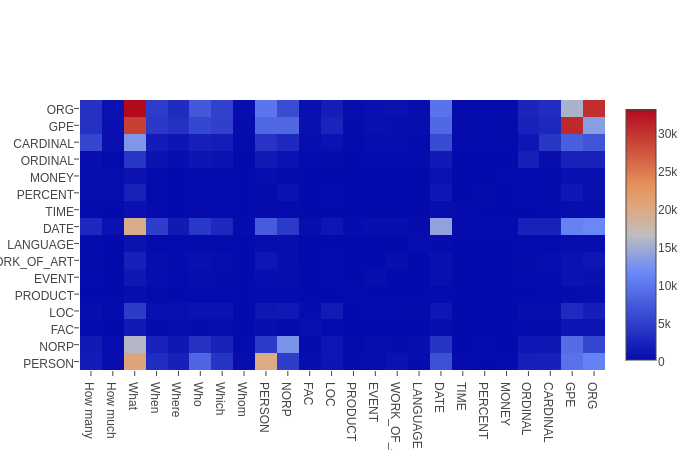

In [212]:
from IPython.display import Image
Image(filename='co_occ_heatmap.png')

### Normalizing the matrix to bring out the patterns

In [22]:
from sklearn.preprocessing import normalize
normed_matrix = normalize(co_occ_matrix, axis=1, norm='l1')    #dividing by sum of row...
normed_matrix

/data/Environment/finite_env/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning:

Data with input dtype int64 was converted to float64 by the normalize function.



array([[ 0.0783168 ,  0.07345576,  0.00810174,  0.02072081,  0.00147304,
         0.00761072,  0.00854365,  0.00255328,  0.13350683,  0.00549936,
         0.01620348,  0.01144064,  0.0239615 ,  0.26323284,  0.17244427,
         0.17293528],
       [ 0.07683044,  0.06478805,  0.00481696,  0.02023121,  0.00337187,
         0.00626204,  0.00433526,  0.00433526,  0.17557803,  0.00578035,
         0.08092486,  0.08477842,  0.01950867,  0.12716763,  0.15655106,
         0.16473988],
       [ 0.13890979,  0.10631921,  0.00982421,  0.03023196,  0.00307763,
         0.00872218,  0.01399043,  0.0055236 ,  0.12977099,  0.00432077,
         0.0143197 ,  0.00573863,  0.02677131,  0.08593162,  0.19507311,
         0.22147484],
       [ 0.1373212 ,  0.09726918,  0.00788903,  0.02514088,  0.00260078,
         0.01096662,  0.01278717,  0.00420459,  0.20390117,  0.00424794,
         0.00229736,  0.00394452,  0.03424361,  0.07238838,  0.1852189 ,
         0.19557867],
       [ 0.14392697,  0.09007917,  0

In [23]:
normed_matrix_df = pd.DataFrame(normed_matrix, index = row_list, columns= column_list)
normed_matrix_df

,PERSON,NORP,FAC,LOC,PRODUCT,EVENT,WORK_OF_ART,LANGUAGE,DATE,TIME,PERCENT,MONEY,ORDINAL,CARDINAL,GPE,ORG
How many,0.078317,0.073456,0.008102,0.020721,0.001473,0.007611,0.008544,0.002553,0.133507,0.005499,0.016203,0.011441,0.023962,0.263233,0.172444,0.172935
How much,0.076830,0.064788,0.004817,0.020231,0.003372,0.006262,0.004335,0.004335,0.175578,0.005780,0.080925,0.084778,0.019509,0.127168,0.156551,0.164740
What,0.138910,0.106319,0.009824,0.030232,0.003078,0.008722,0.013990,0.005524,0.129771,0.004321,0.014320,0.005739,0.026771,0.085932,0.195073,0.221475
When,0.137321,0.097269,0.007889,0.025141,0.002601,0.010967,0.012787,0.004205,0.203901,0.004248,0.002297,0.003945,0.034244,0.072388,0.185219,0.195579
Where,0.143927,0.090079,0.021682,0.041153,0.002568,0.007917,0.010841,0.003281,0.101847,0.002354,0.002710,0.002568,0.028315,0.069039,0.252193,0.219528
Who,0.247078,0.104469,0.006642,0.020752,0.002716,0.008620,0.015645,0.002981,0.123627,0.002745,0.002775,0.003100,0.029490,0.058301,0.161530,0.209529
Which,0.165109,0.096788,0.014403,0.034883,0.003739,0.008838,0.015041,0.004546,0.117735,0.003399,0.006331,0.005396,0.029062,0.073802,0.207767,0.213163
Whom,0.241267,0.106418,0.008123,0.019496,0.000812,0.010561,0.011373,0.004062,0.121852,0.000000,0.003249,0.003249,0.032494,0.049553,0.175467,0.212023
PERSON,0.333952,0.073162,0.008399,0.019311,0.002631,0.006729,0.018248,0.004014,0.125512,0.003575,0.003373,0.004014,0.023949,0.064139,0.143221,0.165770
NORP,0.108221,0.288184,0.004982,0.030901,0.002640,0.007874,0.009734,0.009298,0.099819,0.002135,0.016277,0.003076,0.019629,0.065520,0.193668,0.138043


### Heatmap of the normed matrix


In [24]:
normed_matrix_df['Tags'] = normed_matrix_df.index

#normalized heatmap
melt_normed_matrix_df = pd.melt(normed_matrix_df,id_vars = ['Tags'])
melt_normed_matrix_df.head()


import plotly.plotly as py
import plotly.graph_objs as go

trace = go.Heatmap(z=melt_normed_matrix_df['value'],
                  x=melt_normed_matrix_df['Tags'] ,
                  y=melt_normed_matrix_df['variable'])
data=[trace]
py.iplot(data)

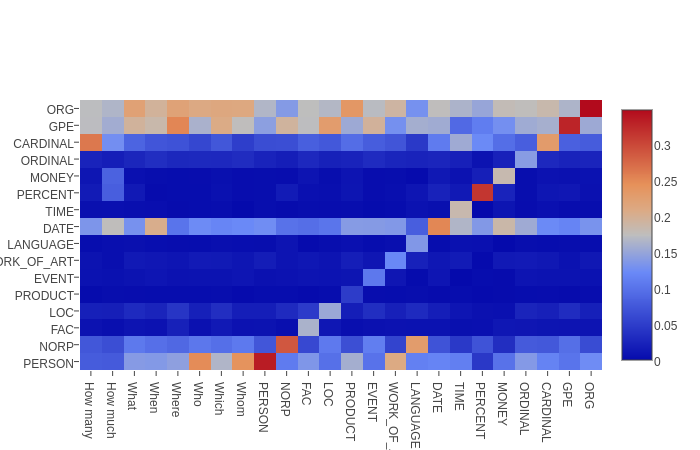

In [213]:
from IPython.display import Image
Image(filename='co_occ_norm_heatmap.png')

### new_normed_matrix

In [27]:
new_normed_matrix  = 1 - normed_matrix
new_normed_matrix_df = pd.DataFrame(new_normed_matrix, index = row_list, columns= column_list)
new_normed_matrix_df['Tags'] = new_normed_matrix_df.index

In [41]:
new_normed_matrix_df

,PERSON,NORP,FAC,LOC,PRODUCT,EVENT,WORK_OF_ART,LANGUAGE,DATE,TIME,PERCENT,MONEY,ORDINAL,CARDINAL,GPE,ORG,Tags
How many,0.921683,0.926544,0.991898,0.979279,0.998527,0.992389,0.991456,0.997447,0.866493,0.994501,0.983797,0.988559,0.976038,0.736767,0.827556,0.827065,How many
How much,0.923170,0.935212,0.995183,0.979769,0.996628,0.993738,0.995665,0.995665,0.824422,0.994220,0.919075,0.915222,0.980491,0.872832,0.843449,0.835260,How much
What,0.861090,0.893681,0.990176,0.969768,0.996922,0.991278,0.986010,0.994476,0.870229,0.995679,0.985680,0.994261,0.973229,0.914068,0.804927,0.778525,What
When,0.862679,0.902731,0.992111,0.974859,0.997399,0.989033,0.987213,0.995795,0.796099,0.995752,0.997703,0.996055,0.965756,0.927612,0.814781,0.804421,When
Where,0.856073,0.909921,0.978318,0.958847,0.997432,0.992083,0.989159,0.996719,0.898153,0.997646,0.997290,0.997432,0.971685,0.930961,0.747807,0.780472,Where
Who,0.752922,0.895531,0.993358,0.979248,0.997284,0.991380,0.984355,0.997019,0.876373,0.997255,0.997225,0.996900,0.970510,0.941699,0.838470,0.790471,Who
Which,0.834891,0.903212,0.985597,0.965117,0.996261,0.991162,0.984959,0.995454,0.882265,0.996601,0.993669,0.994604,0.970938,0.926198,0.792233,0.786837,Which
Whom,0.758733,0.893582,0.991877,0.980504,0.999188,0.989439,0.988627,0.995938,0.878148,1.000000,0.996751,0.996751,0.967506,0.950447,0.824533,0.787977,Whom
PERSON,0.666048,0.926838,0.991601,0.980689,0.997369,0.993271,0.981752,0.995986,0.874488,0.996425,0.996627,0.995986,0.976051,0.935861,0.856779,0.834230,PERSON
NORP,0.891779,0.711816,0.995018,0.969099,0.997360,0.992126,0.990266,0.990702,0.900181,0.997865,0.983723,0.996924,0.980371,0.934480,0.806332,0.861957,NORP


In [28]:
new_normed_matrix

array([[ 0.9216832 ,  0.92654424,  0.99189826,  0.97927919,  0.99852696,
         0.99238928,  0.99145635,  0.99744672,  0.86649317,  0.99450064,
         0.98379652,  0.98855936,  0.9760385 ,  0.73676716,  0.82755573,
         0.82706472],
       [ 0.92316956,  0.93521195,  0.99518304,  0.97976879,  0.99662813,
         0.99373796,  0.99566474,  0.99566474,  0.82442197,  0.99421965,
         0.91907514,  0.91522158,  0.98049133,  0.87283237,  0.84344894,
         0.83526012],
       [ 0.86109021,  0.89368079,  0.99017579,  0.96976804,  0.99692237,
         0.99127782,  0.98600957,  0.9944764 ,  0.87022901,  0.99567923,
         0.9856803 ,  0.99426137,  0.97322869,  0.91406838,  0.80492689,
         0.77852516],
       [ 0.8626788 ,  0.90273082,  0.99211097,  0.97485912,  0.99739922,
         0.98903338,  0.98721283,  0.99579541,  0.79609883,  0.99575206,
         0.99770264,  0.99605548,  0.96575639,  0.92761162,  0.8147811 ,
         0.80442133],
       [ 0.85607303,  0.90992083,  0

In [29]:
melt_new_normed_matrix_df = pd.melt(new_normed_matrix_df,id_vars = ['Tags'])
melt_new_normed_matrix_df.head()

,Tags,variable,value
0,How many,PERSON,0.921683
1,How much,PERSON,0.923170
2,What,PERSON,0.861090
3,When,PERSON,0.862679
4,Where,PERSON,0.856073


In [30]:
answer_dict = {'LOC': 1,'PERSON': 2,'NORP': 3,'FAC': 4,'PRODUCT': 5,'EVENT': 6,'WORK_OF_ART': 7,'LANGUAGE': 8,'DATE':9,'TIME': 10,'PERCENT': 11,'MONEY': 12,'ORDINAL': 13,'CARDINAL': 14,'GPE': 15, 'ORG': 16}
question_dict = {'LOC': 10,
                 'PERSON': 20,
                 'NORP': 30,
                 'FAC': 40,
                 'PRODUCT': 50,
                 'EVENT':60,
                 'WORK_OF_ART':70,
                 'LANGUAGE':80,
                 'DATE': 90,
                 'TIME': 100,
                 'PERCENT': 110,
                 'MONEY': 120,
                 'ORDINAL':130,
                 'CARDINAL': 140,
                 'GPE': 150,
                 'ORG': 160,
                 'How many': 170,
                 'How much': 180,
                 'What': 190,
                 'When': 200,
                 'Where': 210,
                 'Who': 220,
                 'Which':230,
                 'Whom': 240}

In [31]:
melt_new_normed_matrix_df_1 = melt_new_normed_matrix_df.copy()
melt_new_normed_matrix_df_1["Tags"].replace(question_dict, inplace=True)
melt_new_normed_matrix_df_1['variable'].replace(answer_dict, inplace = True)

In [32]:
melt_new_normed_matrix_df_1

,Tags,variable,value
0,170,2,0.921683
1,180,2,0.923170
2,190,2,0.861090
3,200,2,0.862679
4,210,2,0.856073
5,220,2,0.752922
6,230,2,0.834891
7,240,2,0.758733
8,20,2,0.666048
9,30,2,0.891779


### Surpriselib for latent factor

In [33]:
from surprise import SVDpp
from surprise import Dataset
from surprise import accuracy, Reader
reader_new = Reader(line_format='user item rating', sep='\t', rating_scale=(0,1))

In [34]:
csv_file_1 = melt_new_normed_matrix_df_1.to_csv("new_melt.txt", sep= '\t', header = False, index = False)

In [35]:
reader_new = Reader(line_format='user item rating', sep='\t', rating_scale=(0,1))
melt_1 = Dataset.load_from_file("/data/new_melt.txt", reader_new)
print(melt_1)

In [36]:
len(melt_1.raw_ratings)

384

In [37]:
import math
from sklearn.metrics import mean_squared_error

In [38]:
#for the new melt_1
reconstruction_error_1 = []
for i in range(20):
    
    algo = SVDpp(n_factors=i)
    
    for trainset, testset in melt_1.folds():
        algo.train(trainset)
        predictions_svdpp = algo.test(testset)
        
    
    reconstruct = np.dot(algo.pu, algo.qi.T)
    rmse = mean_squared_error(new_normed_matrix, reconstruct)**0.5
    reconstruction_error_1.append(rmse)
    print(i, rmse)

0 0.940443108281
1 0.940503471985
2 0.939704747783
3 0.939653888099
4 0.9412785149
5 0.940321615215
6 0.940476452913
7 0.938426156137
8 0.944616681276
9 0.938811299109
10 0.941626059211
11 0.941386180561
12 0.941726385634
13 0.942602990292
14 0.940876886097
15 0.940038601235
16 0.938987004386
17 0.943634799837
18 0.938661372812
19 0.942117548647


In [39]:
#we are taking the tenth factor
algo = SVDpp(n_factors=10)
    
for trainset, testset in melt_1.folds():
    algo.train(trainset)
    predictions_svdpp = algo.test(testset)
    svdpp_df = pd.DataFrame(predictions_svdpp)

In [48]:
svdpp_df #on testset

,uid,iid,r_ui,est,details,error
0,160,12,0.992595,0.979602,{'was_impossible': False},0.012994
1,10,9,0.897031,0.902531,{'was_impossible': False},-0.005499
2,140,10,0.993869,0.966682,{'was_impossible': False},0.027188
3,140,15,0.840949,0.804340,{'was_impossible': False},0.036609
4,90,12,0.986624,1.000000,{'was_impossible': False},-0.013376
5,190,13,0.973229,0.950446,{'was_impossible': False},0.022782
6,230,16,0.786837,0.800166,{'was_impossible': False},-0.013329
7,40,6,0.990769,1.000000,{'was_impossible': False},-0.009231
8,90,10,0.994671,0.996797,{'was_impossible': False},-0.002126
9,50,2,0.842015,0.888185,{'was_impossible': False},-0.046170


In [40]:
 #r_ui observed and est being the estimated 
svdpp_df['error'] = svdpp_df.r_ui - svdpp_df.est #error =  observed - estimated
svdpp_df.head()

,uid,iid,r_ui,est,details,error
0,160,12,0.992595,0.979602,{'was_impossible': False},0.012994
1,10,9,0.897031,0.902531,{'was_impossible': False},-0.005499
2,140,10,0.993869,0.966682,{'was_impossible': False},0.027188
3,140,15,0.840949,0.804340,{'was_impossible': False},0.036609
4,90,12,0.986624,1.000000,{'was_impossible': False},-0.013376


In [47]:
#outliers

print(svdpp_df[svdpp_df.error > 0.1])
print(svdpp_df[svdpp_df.error < -0.06])

   uid iid      r_ui       est                    details    error
39  80   9  0.919223  0.811213  {'was_impossible': False}  0.10801
    uid iid      r_ui       est                    details     error
14  170  14  0.736767  0.892760  {'was_impossible': False} -0.155992
27   70   2  0.790569  0.889098  {'was_impossible': False} -0.098530
28   10   1  0.847556  0.984009  {'was_impossible': False} -0.136454
50   70   7  0.879057  0.991273  {'was_impossible': False} -0.112216
60  200   9  0.796099  0.857051  {'was_impossible': False} -0.060953
61  120  12  0.817073  0.997746  {'was_impossible': False} -0.180673
75  160  16  0.652041  0.886410  {'was_impossible': False} -0.234368


### Residual boxplot

In [42]:
trace = go.Box(y=svdpp_df['error'], boxpoints='all', jitter=0.3, pointpos=0)
data=[trace]
py.iplot(data)

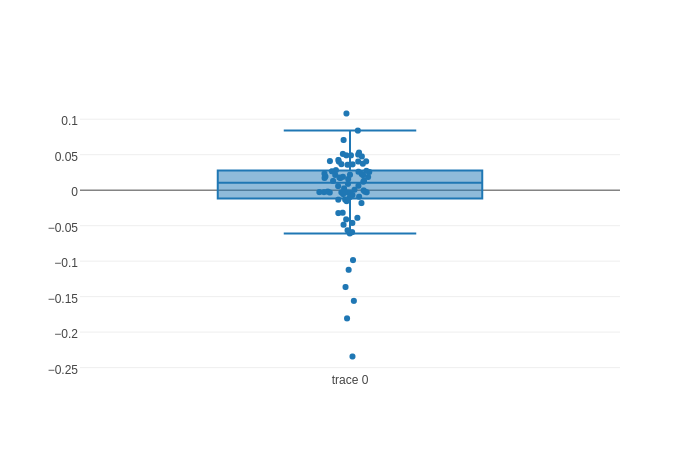

In [214]:
from IPython.display import Image
Image(filename='residual_boxplot.png')

In [36]:
reconstruct = np.dot(algo.pu, algo.qi.T) #reconstructed matrix
rmse = mean_squared_error(new_normed_matrix, reconstruct)**0.5  

In [64]:
reconstruct

array([[  3.49239732e-02,  -3.78291591e-03,  -1.33694397e-02,
          5.39935230e-02,  -4.72110617e-02,  -6.73761971e-02,
         -1.64178684e-02,   5.18645932e-02,  -2.76183902e-02,
          8.05943397e-03,   2.22374368e-02,   1.74339011e-02,
          4.22076657e-02,   2.00655141e-02,  -1.26687982e-02,
          1.52699555e-02],
       [ -3.21455005e-03,   4.48633098e-02,   1.96386671e-02,
          3.48174508e-02,   2.29910469e-02,  -1.70595340e-02,
         -2.06394897e-02,   8.26404832e-03,  -3.08441868e-03,
          1.56793896e-02,   3.06641641e-02,   5.64056476e-03,
         -3.35462011e-02,  -1.23839463e-02,  -8.69544524e-03,
         -3.92754846e-02],
       [  1.26173124e-04,  -3.67968948e-02,   9.49537700e-03,
          3.42088858e-02,  -2.46340861e-02,  -2.40920805e-02,
         -2.98979746e-03,  -1.67913504e-04,   1.42910766e-02,
          2.42245495e-02,   1.96462928e-02,   7.95977137e-03,
          2.73865836e-02,   2.15289387e-02,  -2.88589981e-02,
          4.6705

In [38]:
reconstruct_error = new_normed_matrix - reconstruct
reconstruct_error

array([[ 0.88675922,  0.93032716,  1.0052677 ,  0.92528567,  1.04573802,
         1.05976547,  1.00787422,  0.94558213,  0.89411157,  0.9864412 ,
         0.96155909,  0.97112546,  0.93383083,  0.71670165,  0.84022453,
         0.81179476],
       [ 0.92638411,  0.89034864,  0.97554438,  0.94495134,  0.97363708,
         1.01079749,  1.01630423,  0.98740069,  0.82750638,  0.97854026,
         0.88841098,  0.90958102,  1.01403753,  0.88521632,  0.85214439,
         0.8745356 ],
       [ 0.86096403,  0.93047768,  0.98068041,  0.93555915,  1.02155646,
         1.0153699 ,  0.98899937,  0.99464431,  0.85593793,  0.97145468,
         0.96603401,  0.9863016 ,  0.9458421 ,  0.89253944,  0.83378589,
         0.77385462],
       [ 0.84460203,  0.89544313,  1.02174023,  0.93687853,  0.9875192 ,
         1.00889659,  0.98419432,  0.94130608,  0.83956835,  1.02069506,
         0.99933317,  0.98983894,  1.01534962,  0.92129497,  0.80341405,
         0.80780686],
       [ 0.87891221,  0.86040879,  0

In [39]:
reconstruct_error_df = pd.DataFrame(reconstruct_error,index = row_list,columns = column_list)
reconstruct_error_df

,PERSON,NORP,FAC,LOC,PRODUCT,EVENT,WORK_OF_ART,LANGUAGE,DATE,TIME,PERCENT,MONEY,ORDINAL,CARDINAL,GPE,ORG
How many,0.886759,0.930327,1.005268,0.925286,1.045738,1.059765,1.007874,0.945582,0.894112,0.986441,0.961559,0.971125,0.933831,0.716702,0.840225,0.811795
How much,0.926384,0.890349,0.975544,0.944951,0.973637,1.010797,1.016304,0.987401,0.827506,0.978540,0.888411,0.909581,1.014038,0.885216,0.852144,0.874536
What,0.860964,0.930478,0.980680,0.935559,1.021556,1.015370,0.988999,0.994644,0.855938,0.971455,0.966034,0.986302,0.945842,0.892539,0.833786,0.773855
When,0.844602,0.895443,1.021740,0.936879,0.987519,1.008897,0.984194,0.941306,0.839568,1.020695,0.999333,0.989839,1.015350,0.921295,0.803414,0.807807
Where,0.878912,0.860409,0.953745,0.939200,0.999542,1.000967,1.012402,0.983131,0.901649,1.021154,0.987439,0.997180,0.985071,0.938370,0.762218,0.781675
Who,0.778501,0.931672,1.004113,0.950122,1.012071,0.977686,0.958614,1.014223,0.853503,0.993738,0.993057,0.986279,0.964709,0.927313,0.878860,0.772961
Which,0.803548,0.893115,0.979201,1.031581,1.018943,1.001743,1.011407,0.998222,0.881956,1.029477,1.028174,1.022237,0.958259,0.921037,0.755736,0.759749
Whom,0.771387,0.869046,0.998959,0.961480,1.023337,0.995014,0.999776,0.997318,0.873863,0.957304,0.980602,0.985580,0.993851,0.977835,0.840394,0.798257
PERSON,0.681030,0.948903,0.957924,1.040806,0.980675,0.952029,0.998161,0.979752,0.874425,0.990421,1.011519,1.018450,0.979639,0.948791,0.852387,0.888268
NORP,0.839059,0.694352,0.989709,0.979338,1.016330,1.029697,1.020301,0.996963,0.902362,1.041245,0.989704,1.022718,0.998554,0.948286,0.788232,0.859147


### Error plot

In [40]:

import plotly.graph_objs as go

trace1 = go.Bar(
    x=row_list[0:8],
    y=reconstruct_error_df['PERSON'][0:8],
    name='PERSON'
)
trace2 = go.Bar(
    x=row_list[0:8],
    y= reconstruct_error_df['NORP'][0:8],
    name='NORP'
)
trace3 = go.Bar(
    x=row_list[0:8],
    y=reconstruct_error_df['FAC'][0:8],
    name='FAC'
)
trace4 = go.Bar(
    x=row_list[0:8],
    y= reconstruct_error_df['LOC'][0:8],
    name='LOC'
)


trace5 = go.Bar(
    x=row_list[0:8],
    y=reconstruct_error_df['PRODUCT'][0:8],
    name='PRODUCT'
)
trace6 = go.Bar(
    x=row_list[0:8],
    y=reconstruct_error_df['EVENT'][0:8],
    name='EVENT'
)


trace7= go.Bar(
    x=row_list[0:8],
    y=reconstruct_error_df['WORK_OF_ART'][0:8],
    name='WORK_OF_ART'
)
trace8 = go.Bar(
    x=row_list[0:8],
    y= reconstruct_error_df['LANGUAGE'][0:8],
    name='LANGUAGE'
)



trace9 = go.Bar(
    x=row_list[0:8],
    y= reconstruct_error_df['DATE'][0:8],
    name='DATE'
)
trace10= go.Bar(
    x=row_list[0:8],
    y=reconstruct_error_df['TIME'][0:8],
    name='TIME'
)
trace11 = go.Bar(
    x=row_list[0:8],
    y= reconstruct_error_df['PERCENT'][0:8],
    name='PERCENT'
)



trace12 = go.Bar(
    x=row_list[0:8],
    y= reconstruct_error_df['MONEY'][0:8],
    name='MONEY'
)
trace13= go.Bar(
    x=row_list[0:8],
    y=reconstruct_error_df['ORDINAL'][0:8],
    name='ORDINAL'
)
trace14 = go.Bar(
    x=row_list[0:8],
    y= reconstruct_error_df['CARDINAL'][0:8],
    name='CARDINAL'
)


trace15= go.Bar(
    x=row_list[0:8],
    y=reconstruct_error_df['GPE'][0:8],
    name='GPE'
)
trace16 = go.Bar(
    x=row_list[0:8],
    y= reconstruct_error_df['ORG'][0:8],
    name='ORG'
)



data = [trace1, trace2,trace3,trace4,trace5, trace6,trace7,trace8,trace9, trace10,trace11,
        trace12,trace13,trace14,trace15,trace16]
layout = go.Layout(
    barmode='group'
) 



In [41]:
trace1 = go.Bar(
    x=row_list[8:16],
    y=reconstruct_error_df['PERSON'][8:16],
    name='PERSON'
)
trace2 = go.Bar(
    x=row_list[8:16],
    y= reconstruct_error_df['NORP'][8:16],
    name='NORP'
)
trace3 = go.Bar(
    x=row_list[8:16],
    y=reconstruct_error_df['FAC'][8:16],
    name='FAC'
)
trace4 = go.Bar(
    x=row_list[8:16],
    y= reconstruct_error_df['LOC'][8:16],
    name='LOC'
)


trace5 = go.Bar(
    x=row_list[8:16],
    y=reconstruct_error_df['PRODUCT'][8:16],
    name='PRODUCT'
)
trace6 = go.Bar(
    x=row_list[8:16],
    y=reconstruct_error_df['EVENT'][8:16],
    name='EVENT'
)


trace7= go.Bar(
    x=row_list[8:16],
    y=reconstruct_error_df['WORK_OF_ART'][8:16],
    name='WORK_OF_ART'
)
trace8 = go.Bar(
    x=row_list[8:16],
    y= reconstruct_error_df['LANGUAGE'][8:16],
    name='LANGUAGE'
)



trace9 = go.Bar(
    x=row_list[8:16],
    y= reconstruct_error_df['DATE'][8:16],
    name='DATE'
)
trace10= go.Bar(
    x=row_list[8:16],
    y=reconstruct_error_df['TIME'][8:16],
    name='TIME'
)
trace11 = go.Bar(
    x=row_list[8:16],
    y= reconstruct_error_df['PERCENT'][8:16],
    name='PERCENT'
)



trace12 = go.Bar(
    x=row_list[8:16],
    y= reconstruct_error_df['MONEY'][8:16],
    name='MONEY'
)
trace13= go.Bar(
    x=row_list[8:16],
    y=reconstruct_error_df['ORDINAL'][8:16],
    name='ORDINAL'
)
trace14 = go.Bar(
    x=row_list[8:16],
    y= reconstruct_error_df['CARDINAL'][8:16],
    name='CARDINAL'
)


trace15= go.Bar(
    x=row_list[8:16],
    y=reconstruct_error_df['GPE'][8:16],
    name='GPE'
)
trace16 = go.Bar(
    x=row_list[8:16],
    y= reconstruct_error_df['ORG'][8:16],
    name='ORG'
)



data1 = [trace1, trace2,trace3,trace4,trace5, trace6,trace7,trace8,trace9, trace10,trace11,
        trace12,trace13,trace14,trace15,trace16]
layout = go.Layout(
         barmode='group'
) 




In [42]:
trace1 = go.Bar(
    x=row_list[16:24],
    y=reconstruct_error_df['PERSON'][16:24],
    name='PERSON'
)
trace2 = go.Bar(
    x=row_list[16:24],
    y= reconstruct_error_df['NORP'][16:24],
    name='NORP'
)
trace3 = go.Bar(
    x=row_list[16:24],
    y=reconstruct_error_df['FAC'][16:24],
    name='FAC'
)
trace4 = go.Bar(
    x=row_list[16:24],
    y= reconstruct_error_df['LOC'][16:24],
    name='LOC'
)


trace5 = go.Bar(
    x=row_list[16:24],
    y=reconstruct_error_df['PRODUCT'][16:24],
    name='PRODUCT'
)
trace6 = go.Bar(
    x=row_list[16:24],
    y= reconstruct_error_df['EVENT'][16:24],
    name='EVENT'
)


trace7= go.Bar(
    x=row_list[16:24],
    y=reconstruct_error_df['WORK_OF_ART'][16:24],
    name='WORK_OF_ART'
)
trace8 = go.Bar(
    x=row_list[16:24],
    y= reconstruct_error_df['LANGUAGE'][16:24],
    name='LANGUAGE'
)



trace9 = go.Bar(
    x=row_list[16:24],
    y= reconstruct_error_df['DATE'][16:24],
    name='DATE'
)
trace10= go.Bar(
    x=row_list[16:24],
    y=reconstruct_error_df['TIME'][16:24],
    name='TIME'
)
trace11 = go.Bar(
    x=row_list[16:24],
    y= reconstruct_error_df['PERCENT'][16:24],
    name='PERCENT'
)



trace12 = go.Bar(
    x=row_list[16:24],
    y= reconstruct_error_df['MONEY'][16:24],
    name='MONEY'
)
trace13= go.Bar(
    x=row_list[16:24],
    y=reconstruct_error_df['ORDINAL'][16:24],
    name='ORDINAL'
)
trace14 = go.Bar(
    x=row_list[16:24],
    y=reconstruct_error_df['CARDINAL'][16:24],
    name='CARDINAL'
)


trace15= go.Bar(
    x=row_list[16:24],
    y=reconstruct_error_df['GPE'][16:24],
    name='GPE'
)
trace16 = go.Bar(
    x=row_list[16:24],
    y= reconstruct_error_df['ORG'][16:24],
    name='ORG'
)



data2 = [trace1, trace2,trace3,trace4,trace5, trace6,trace7,trace8,trace9, trace10,trace11,
        trace12,trace13,trace14,trace15,trace16]
layout = go.Layout(
    barmode='group'
) 



In [43]:
#error distribution
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

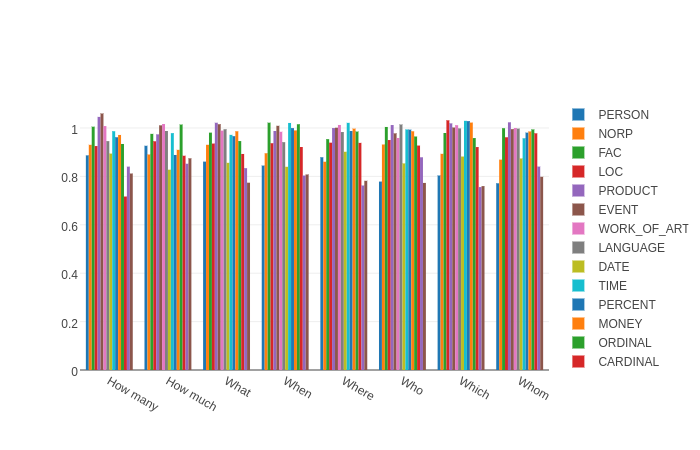

In [215]:
from IPython.display import Image
Image(filename='recon_error1.png')

In [44]:
fig = go.Figure(data=data1, layout=layout)
py.iplot(fig)

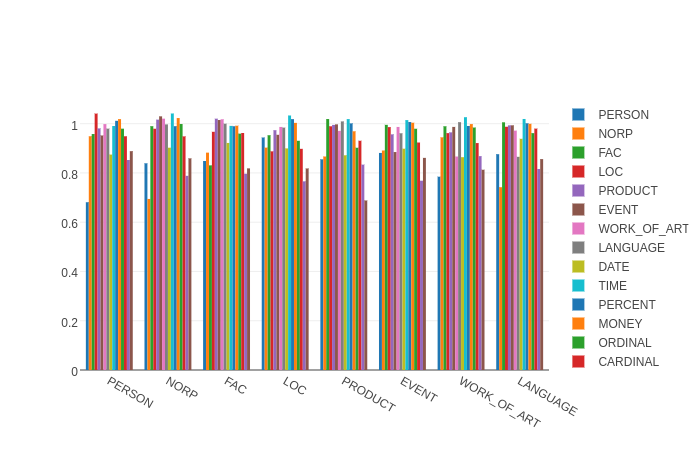

In [216]:
from IPython.display import Image
Image(filename='recon_error2.png')

In [45]:
fig = go.Figure(data=data2, layout=layout)
py.iplot(fig)

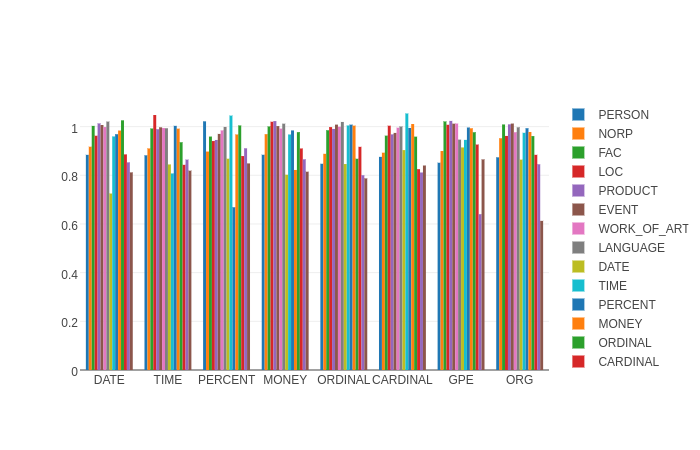

In [217]:
from IPython.display import Image
Image(filename='recon_error3.png')

### Euclidean matrix

In [62]:
row_column_list =['How many',
 'How much',
 'What',
 'When',
 'Where',
 'Who',
 'Which',
 'Whom',
 'q_PERSON',
 'q_NORP',
 'q_FAC',
 'q_LOC',
 'q_PRODUCT',
 'q_EVENT',
 'q_WORK_OF_ART',
 'q_LANGUAGE',
 'q_DATE',
 'q_TIME',
 'q_PERCENT',
 'q_MONEY',
 'q_ORDINAL',
 'q_CARDINAL',
 'q_GPE',
 'q_ORG',
 'a_PERSON',
 'a_NORP',
 'a_FAC',
 'a_LOC',
 'a_PRODUCT',
 'a_EVENT',
 'a_WORK_OF_ART',
 'a_LANGUAGE',
 'a_DATE',
 'a_TIME',
 'a_PERCENT',
 'a_MONEY',
 'a_ORDINAL',
 'a_CARDINAL',
 'a_GPE',
 'a_ORG']

In [63]:
qn_ans_list = list(algo.pu) + list(algo.qi)
qn_ans_list

qn_ans_list_copy = qn_ans_list.copy()
len(qn_ans_list_copy)

40

In [64]:
question_answer_dis = np.zeros((len(row_column_list), len(row_column_list))) 

for i in range(len(qn_ans_list)):
    for j in range(len(qn_ans_list_copy)):
        question_answer_dis[i,j] = distance.euclidean(qn_ans_list[i],qn_ans_list_copy[j])


In [65]:
eucli_matrix_df = pd.DataFrame(question_answer_dis, index = row_column_list, columns= row_column_list)
eucli_matrix_df

,How many,How much,What,When,Where,Who,Which,Whom,q_PERSON,q_NORP,...,a_WORK_OF_ART,a_LANGUAGE,a_DATE,a_TIME,a_PERCENT,a_MONEY,a_ORDINAL,a_CARDINAL,a_GPE,a_ORG
How many,0.000000,0.399305,0.356379,0.511892,0.562777,0.460311,0.383470,0.463461,0.256344,0.361117,...,0.410078,0.295805,0.374223,0.315685,0.469707,0.510516,0.354932,0.407265,0.520727,0.522044
How much,0.399305,0.000000,0.404457,0.375172,0.618761,0.493196,0.362765,0.393778,0.272059,0.358474,...,0.317507,0.245931,0.204930,0.307250,0.435956,0.487958,0.272045,0.299122,0.542837,0.506130
What,0.356379,0.404457,0.000000,0.548002,0.531591,0.605001,0.453708,0.505506,0.373708,0.442026,...,0.359975,0.376038,0.482701,0.349401,0.452961,0.529521,0.438518,0.365745,0.577635,0.407658
When,0.511892,0.375172,0.548002,0.000000,0.607041,0.485435,0.452975,0.396614,0.370254,0.438195,...,0.570102,0.437856,0.321389,0.517301,0.411047,0.545053,0.336963,0.457352,0.418657,0.476918
Where,0.562777,0.618761,0.531591,0.607041,0.000000,0.523864,0.628186,0.625243,0.543207,0.358579,...,0.552434,0.538784,0.547882,0.638306,0.501641,0.577997,0.495479,0.426524,0.561737,0.514916
Who,0.460311,0.493196,0.605001,0.485435,0.523864,0.000000,0.306393,0.516981,0.349029,0.382520,...,0.542562,0.474928,0.355929,0.414865,0.314677,0.499187,0.357018,0.403508,0.481634,0.560744
Which,0.383470,0.362765,0.453708,0.452975,0.628186,0.306393,0.000000,0.453652,0.297845,0.397334,...,0.407004,0.360932,0.317638,0.205496,0.310929,0.411997,0.300691,0.379583,0.481344,0.496788
Whom,0.463461,0.393778,0.505506,0.396614,0.625243,0.516981,0.453652,0.000000,0.429885,0.476511,...,0.408540,0.358818,0.346169,0.439768,0.501852,0.508302,0.258985,0.495554,0.374782,0.444239
q_PERSON,0.256344,0.272059,0.373708,0.370254,0.543207,0.349029,0.297845,0.429885,0.000000,0.339403,...,0.417131,0.297613,0.267157,0.258584,0.303348,0.485067,0.284188,0.252497,0.469208,0.440930
q_NORP,0.361117,0.358474,0.442026,0.438195,0.358579,0.382520,0.397334,0.476511,0.339403,0.000000,...,0.379308,0.297898,0.287454,0.427460,0.431754,0.483169,0.271486,0.287486,0.473603,0.525590


In [140]:
eucli_matrix_df.loc[('When'),:]

How many         0.511892
How much         0.375172
What             0.548002
When             0.000000
Where            0.607041
Who              0.485435
Which            0.452975
Whom             0.396614
q_PERSON         0.370254
q_NORP           0.438195
q_FAC            0.567363
q_LOC            0.333682
q_PRODUCT        0.469072
q_EVENT          0.428631
q_WORK_OF_ART    0.484107
q_LANGUAGE       0.583031
q_DATE           0.439019
q_TIME           0.452856
q_PERCENT        0.324834
q_MONEY          0.463754
q_ORDINAL        0.519854
q_CARDINAL       0.472133
q_GPE            0.283957
q_ORG            0.520632
a_PERSON         0.483321
a_NORP           0.364702
a_FAC            0.468502
a_LOC            0.335993
a_PRODUCT        0.370680
a_EVENT          0.457899
a_WORK_OF_ART    0.570102
a_LANGUAGE       0.437856
a_DATE           0.321389
a_TIME           0.517301
a_PERCENT        0.411047
a_MONEY          0.545053
a_ORDINAL        0.336963
a_CARDINAL       0.457352
a_GPE       

### WMD score

In [153]:
def ner_combination(map_que_ner, map_ans_ner):
     
    unique_removed_new_ner = list(set(map_que_ner + map_ans_ner))
    return unique_removed_new_ner
    

In [75]:
#working on a sample 
from gensim.corpora import Dictionary
docu1 = "who is president of US?"
docu2 = "Barack Obama is the president of US."

d1 = docu1.split()
d2 = docu2.split()

In [76]:
question_list = []
l1 = unicodedata.normalize('NFKD', docu1).encode('ascii','ignore').decode('utf-8')
question_list.append(l1)
print(question_list)    
    #Appropriate question type replacement
Question_list = []
for i in range(len(question_list)):
    Question_list.append(replace_all({"how": "How", "when": "When","what": "What","whom": "Whom","which": "Which", "where": "Where" , "who":'Who'}, question_list[i]))
print(Question_list) 


['who is president of US?']
['Who is president of US?']


In [77]:
que_type  = question_type(Question_list)
que_type_clean = question_type_extractor(que_type)

print(que_type)
print(que_type_clean)

['Who is']
['Who']


In [105]:
#extracting question type and NER from the question statement
# map_que_ner = []
# for i in range(len(d1)):
map_que_ner = []
que_ner = nlp(Question_list[0])
for ent in que_ner.ents:
    map_que_ner.append('q_' + ent.label_)

map_que_ner.append(que_type_clean[0])
print(map_que_ner)

['q_GPE', 'Who']


In [106]:
#extracting the answer type from the answer statement
# map_ans_ner = []
# for i in range(len(d2)):
map_ans_ner = []
ans_ner = nlp(docu2)
for ent in ans_ner.ents:
    map_ans_ner.append('a_' + ent.label_)
print(map_ans_ner)

['a_PERSON', 'a_GPE']


In [107]:
new_ner = []
new_ner =  map_que_ner + map_ans_ner
print(new_ner)

['q_GPE', 'Who', 'a_PERSON', 'a_GPE']


In [108]:
unique_removed_new_ner = list(set(new_ner))
unique_removed_new_ner

['a_GPE', 'a_PERSON', 'q_GPE', 'Who']

In [109]:
distance_matrix = np.zeros((len(unique_removed_new_ner), len(unique_removed_new_ner)))
distance_matrix

array([[ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.]])

In [111]:
def word_count(doc_ner_list):
    my_count = {}
    for element in doc_ner_list:
        try: my_count[doc_ner_list.index(element)] += 1
        except KeyError: my_count[doc_ner_list.index(element)] = 1
    a = [(k,v) for k,v in my_count.items()]
    return a

def bag_of_words(doc_ner_list, new_ner):
    dis_matrix = np.zeros(len(new_ner), dtype = float)
    nbow = word_count(doc_ner_list)
    print(doc_ner_list)
    print(nbow)# Word frequencies.
    doc_len = len(doc_ner_list)
    for idx, freq in nbow:
        dis_matrix[idx] = freq / float(doc_len)  # Normalized word frequencies.
    return dis_matrix

d_1 = bag_of_words(map_que_ner, unique_removed_new_ner)
print(d_1)
print()
d_2 = bag_of_words(map_ans_ner, unique_removed_new_ner)
print(d_2)

['q_GPE', 'Who']
[(0, 1), (1, 1)]
[ 0.5  0.5  0.   0. ]

['a_PERSON', 'a_GPE']
[(0, 1), (1, 1)]
[ 0.5  0.5  0.   0. ]


In [84]:
#euclidean distance extraction
sub_matrix_df = eucli_matrix_df.loc[(new_ner),(new_ner)]
print(sub_matrix_df)
sub_matrix= sub_matrix_df.as_matrix()
print(sub_matrix)

             q_GPE       Who  a_PERSON     a_GPE
q_GPE     0.000000  0.432037  0.460945  0.244263
Who       0.432037  0.000000  0.399934  0.481634
a_PERSON  0.460945  0.399934  0.000000  0.445878
a_GPE     0.244263  0.481634  0.445878  0.000000
[[ 0.          0.4320373   0.46094504  0.24426294]
 [ 0.4320373   0.          0.39993418  0.48163407]
 [ 0.46094504  0.39993418  0.          0.44587823]
 [ 0.24426294  0.48163407  0.44587823  0.        ]]


In [85]:
from pyemd import emd
emd(d_1, d_2, sub_matrix)

0.0

In [61]:
#computing the actual gensimwmd distance
word2vec_model.init_sims(replace=True)

In [86]:
word2vec_model.wmdistance(docu1.split(), docu2.split())

0.775104919742701

### WMD score 2 
- Removing the question NER tag 'q_' and working only with the question type and answer NER tags

In [199]:
#working on a sample 
docu1 = "who is president of US?"
docu2 = "Barack Obama is the president of US."


d1 = docu1.split()
d2 = docu2.split()

In [189]:
question_list = []
l1 = unicodedata.normalize('NFKD', docu1).encode('ascii','ignore').decode('utf-8')
question_list.append(l1)
print(question_list)    
    #Appropriate question type replacement
Question_list = []
for i in range(len(question_list)):
    Question_list.append(replace_all({"how": "How", "when": "When","what": "What","whom": "Whom","which": "Which", "where": "Where" , "who":'Who'}, question_list[i]))
print(Question_list) 


['who is president of US?']
['Who is president of US?']


In [190]:
que_type  = question_type(Question_list)
que_type_clean = question_type_extractor(que_type)

print(que_type)
print(que_type_clean)

['Who is']
['Who']


In [191]:
#extracting question type and NER from the question statement
# map_que_ner = []
# for i in range(len(d1)):
map_que_ner = []
map_que_ner.append(que_type_clean[0])
print(map_que_ner)

['Who']


In [192]:
#extracting the answer type from the answer statement
# map_ans_ner = []
# for i in range(len(d2)):
map_ans_ner = []
ans_ner = nlp(docu2)
for ent in ans_ner.ents:
    map_ans_ner.append('a_' + ent.label_)
print(map_ans_ner)

['a_PERSON', 'a_GPE']


In [193]:
new_ner = []
new_ner =  map_que_ner + map_ans_ner
print(new_ner)

unique_removed_new_ner = list(set(new_ner))
print(unique_removed_new_ner)

['Who', 'a_PERSON', 'a_GPE']
['a_GPE', 'a_PERSON', 'Who']


In [194]:
## with question type and answer tag and the corresponding normalized frequencies
def word_count(doc_ner_list):
    count = Counter(doc_ner_list)
    map_count = []
    for i in count.items():
        map_count.append(i)
    return map_count

def bag_of_words(doc_ner_list, unique_ner):
    dis_matrix = np.zeros(len(unique_ner), dtype = float)
    nbow = word_count(doc_ner_list)
   
    doc_len = len(doc_ner_list)
    for i, freq in nbow:
        dis_matrix[unique_ner.index(i)] = freq / float(doc_len)  # Normalized word frequencies.
    return dis_matrix


d_1 = bag_of_words(map_que_ner, unique_removed_new_ner)
print(d_1)
print()
d_2 = bag_of_words(map_ans_ner, unique_removed_new_ner)
print(d_2)

[ 0.  0.  1.]

[ 0.5  0.5  0. ]


In [195]:
#euclidean distance extraction
sub_matrix_df = eucli_matrix_df.loc[(new_ner),(new_ner)]
print(sub_matrix_df)
sub_matrix= sub_matrix_df.as_matrix()
print(sub_matrix)

               Who  a_PERSON     a_GPE
Who       0.000000  0.399934  0.481634
a_PERSON  0.399934  0.000000  0.445878
a_GPE     0.481634  0.445878  0.000000
[[ 0.          0.39993418  0.48163407]
 [ 0.39993418  0.          0.44587823]
 [ 0.48163407  0.44587823  0.        ]]


In [196]:
from pyemd import emd
emd(d_1, d_2, sub_matrix)

0.46375605578386336

In [197]:
#computing the actual gensimwmd distance
word2vec_model.init_sims(replace=True)

In [200]:
word2vec_model.wmdistance(d1, d2)

0.8667996031056009

### WMD Score 3. on several statements
- Given a question and several statements presuming to be the potential answer to the question- Rank it accordingly
- without question NER tags

In [181]:
question = "When was Barack Obama sworn in?"
answer = ["Barack Obama is a nice guy.", "Barack Obama is a nice guy was sworn in 2007.","Barack Obama is a nice guy and was sworn in Washington"]

In [183]:
def word_count(doc_ner_list):
    count = Counter(doc_ner_list)
    map_count = []
    for i in count.items():
        map_count.append(i)
    return map_count

def bag_of_words(doc_ner_list, unique_ner):
    dis_matrix = np.zeros(len(unique_ner), dtype = float)
    nbow = word_count(doc_ner_list)
   
    doc_len = len(doc_ner_list)
    for i, freq in nbow:
        dis_matrix[unique_ner.index(i)] = freq / float(doc_len)  # Normalized word frequencies.
    return dis_matrix


In [182]:
question_list = []
l1 = unicodedata.normalize('NFKD', question).encode('ascii','ignore').decode('utf-8')
question_list.append(l1)
    
#Appropriate question type replacement
Question_list = []
for i in range(len(question_list)):
    Question_list.append(replace_all({"how": "How", "when": "When","what": "What","whom": "Whom","which": "Which", "where": "Where" , "who":'Who'}, question_list[i]))


print('Query:')
print(question)
que_type  = question_type([question])
que_type_clean = question_type_extractor(que_type)

for i in range(len(answer)):
    print()
    
    map_que_ner = []
    map_que_ner.append(que_type_clean[0])
    
    map_ans_ner = []
    ans_ner = nlp(answer[i])
    for ent in ans_ner.ents:
        map_ans_ner.append('a_' + ent.label_)

    unique_ner = ner_combination(map_que_ner, map_ans_ner)

#     distance_matrix = np.zeros((len(unique_ner), len(unique_ner)))
    
    d_1 = bag_of_words(map_que_ner, unique_ner)

    d_2 = bag_of_words(map_ans_ner, unique_ner)
    print("d_1", " " , d_1)
    print("d_2", " " , d_2)
   
    sub_matrix_df = eucli_matrix_df.loc[(unique_ner),(unique_ner)]

    sub_matrix= sub_matrix_df.as_matrix()

    
    score = emd(d_1, d_2, sub_matrix)
    print(answer[i])
    print('Score = ', score)
    print()
    

Query:
When was Barack Obama sworn in?

d_1   [ 0.  1.]
d_2   [ 1.  0.]
Barack Obama is a nice guy.
Score =  0.483320572875241


d_1   [ 0.  0.  1.]
d_2   [ 0.5  0.5  0. ]
Barack Obama is a nice guy was sworn in 2007.
Score =  0.40235495216746703


d_1   [ 0.  0.  1.]
d_2   [ 0.5  0.5  0. ]
Barack Obama is a nice guy and was sworn in Washington
Score =  0.45098884315275173



### For SQuaD sample paragraph
- ***with question NER tags***
- ***Score generated for a single question and the statements from the first paragraph***

In [201]:
paragraph_pointer = sqd_data.data[0]['paragraphs'] 
processed_sen_list, process_sen_token_list = preprocess_text(paragraph_pointer[0]['context'])
print(processed_sen_list)
processed_que_list = preprocess_question(paragraph_pointer[0]['qas'])
print()
print(processed_que_list)

['Architecturally, the school has a Catholic character.', "Atop the Main Building's gold dome is a golden statue of the Virgin Mary.", 'Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes".', 'Next to the Main Building is the Basilica of the Sacred Heart.', 'Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection.', 'It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858.', 'At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.']

['To Whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?', 'What is in front of the Notre Dame Main Building?', 'The Basilica of the Sacred heart at Notre Dame is beside to Which structure?', 'What is the Grotto at Notre Dame?', 'What sits on top of the Main Build

In [202]:
def word_count(doc_ner_list):
    count = Counter(doc_ner_list)
    map_count = []
    for i in count.items():
        map_count.append(i)
    return map_count

def bag_of_words(doc_ner_list, unique_ner):
    dis_matrix = np.zeros(len(unique_ner), dtype = float)
    nbow = word_count(doc_ner_list)
   
    doc_len = len(doc_ner_list)
    for i, freq in nbow:
        dis_matrix[unique_ner.index(i)] = freq / float(doc_len)  # Normalized word frequencies.
    return dis_matrix

In [207]:
# Print the query and the retrieved documents, together with their similarities.
query = processed_que_list[0]
print('Query:')
print(query)
que_type  = question_type([query])
que_type_clean = question_type_extractor(que_type)

for i in range(len(processed_sen_list)):
    print()
    
    map_que_ner = []

    que_ner = nlp(query)
    for ent in que_ner.ents:
        map_que_ner.append('q_' + ent.label_)
    map_que_ner.append(que_type_clean[0])
    print("Que_NER", " ", map_que_ner)
    
    
    map_ans_ner = []
    ans_ner = nlp(processed_sen_list[i])
    for ent in ans_ner.ents:
        map_ans_ner.append('a_' + ent.label_)
    print("Ans_NER", " ", map_ans_ner)

    unique_ner = ner_combination(map_que_ner, map_ans_ner)
    print("Unique_NER", " ", unique_ner)
    
   # distance_matrix = np.zeros((len(unique_ner), len(unique_ner)))
    
    d_1 = bag_of_words(map_que_ner, unique_ner)
    print("Question", " ", d_1)
    d_2 = bag_of_words(map_ans_ner, unique_ner)
    print("Answer", " ", d_2)
    print()
    sub_matrix_df = eucli_matrix_df.loc[(unique_ner),(unique_ner)]
    print(sub_matrix_df)
    print()
    sub_matrix= sub_matrix_df.as_matrix()
#     print(sub_matrix)
    
    score = emd(d_1, d_2, sub_matrix)
    print(processed_sen_list[i])
    print('Score = ', score)
    print()
    print("*******************************************************************************************************")
    

Query:
To Whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?

Que_NER   ['q_DATE', 'q_GPE', 'Whom']
Ans_NER   ['a_NORP']
Unique_NER   ['Whom', 'q_DATE', 'q_GPE', 'a_NORP']
Question   [ 0.33333333  0.33333333  0.33333333  0.        ]
Answer   [ 0.  0.  0.  1.]

            Whom    q_DATE     q_GPE    a_NORP
Whom    0.000000  0.443136  0.327789  0.380840
q_DATE  0.443136  0.000000  0.386425  0.309990
q_GPE   0.327789  0.386425  0.000000  0.236309
a_NORP  0.380840  0.309990  0.236309  0.000000

Architecturally, the school has a Catholic character.
Score =  0.30904597044027976

*******************************************************************************************************

Que_NER   ['q_DATE', 'q_GPE', 'Whom']
Ans_NER   ['a_FAC', 'a_PERSON']
Unique_NER   ['a_PERSON', 'Whom', 'q_DATE', 'q_GPE', 'a_FAC']
Question   [ 0.          0.33333333  0.33333333  0.33333333  0.        ]
Answer   [ 0.5  0.   0.   0.   0.5]

          a_PERSON      Whom    q_DATE     q_GPE     a

#### Excluding the question NER tag

In [208]:
# Print the query and the retrieved documents, together with their similarities.
query = processed_que_list[0]
print('Query:')
print(query)
que_type  = question_type([query])
que_type_clean = question_type_extractor(que_type)
for i in range(len(processed_sen_list)):
    print()
    
    map_que_ner = []
    map_que_ner.append(que_type_clean[0])
    print("Que_NER", " ", map_que_ner)
    
    
    map_ans_ner = []
    ans_ner = nlp(processed_sen_list[i])
    for ent in ans_ner.ents:
        map_ans_ner.append('a_' + ent.label_)
    print("Ans_NER", " ", map_ans_ner)

    unique_ner = ner_combination(map_que_ner, map_ans_ner)
    print("Unique_NER", " ", unique_ner)
    print()
    distance_matrix = np.zeros((len(unique_ner), len(unique_ner)))
    
    d_1 = bag_of_words(map_que_ner, unique_ner)
#     print(d_1)
    d_2 = bag_of_words(map_ans_ner, unique_ner)
    
    sub_matrix_df = eucli_matrix_df.loc[(unique_ner),(unique_ner)]
#     print(sub_matrix_df)
    sub_matrix= sub_matrix_df.as_matrix()
#     print(sub_matrix)
    
    score = emd(d_1, d_2, sub_matrix)
    print(processed_sen_list[i])
    print('Score = ', score)
    print()
    print("**************************************************************************************************")

Query:
To Whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?

Que_NER   ['Whom']
Ans_NER   ['a_NORP']
Unique_NER   ['Whom', 'a_NORP']

Architecturally, the school has a Catholic character.
Score =  0.38083962780046443

**************************************************************************************************

Que_NER   ['Whom']
Ans_NER   ['a_FAC', 'a_PERSON']
Unique_NER   ['Whom', 'a_PERSON', 'a_FAC']

Atop the Main Building's gold dome is a golden statue of the Virgin Mary.
Score =  0.5453420473228813

**************************************************************************************************

Que_NER   ['Whom']
Ans_NER   ['a_FAC', 'a_NORP', 'a_WORK_OF_ART']
Unique_NER   ['Whom', 'a_WORK_OF_ART', 'a_FAC', 'a_NORP']

Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes".
Score =  0.4421704463970198

********************************************************************

### WMD score generated for all combinations of questions and statements from paragraph 1, context 1:
- question NER tag included

In [248]:
for i in range(len(processed_que_list)):
    print('Query:', " ", i)
    print(processed_que_list[i])
    print("Answer:")
    print(paragraph_pointer[0]['qas'][i]['answers'][0]['text'])
    print()
    
    que_type  = question_type([processed_que_list[i]])
    que_type_clean = question_type_extractor(que_type)
    
    for j in range(len(processed_sen_list)):
        

    
        map_que_ner = []
        map_que_ner.append(que_type_clean[0])
        print("Que_NER", " ", map_que_ner)


        map_ans_ner = []
        ans_ner = nlp(processed_sen_list[j])
        for ent in ans_ner.ents:
            map_ans_ner.append('a_' + ent.label_)
        print("Ans_NER", " ", map_ans_ner)

        unique_ner = ner_combination(map_que_ner, map_ans_ner)
        print("Unique_NER", " ", unique_ner)
        print()
       # distance_matrix = np.zeros((len(unique_ner), len(unique_ner)))

        d_1 = bag_of_words(map_que_ner, unique_ner)
    #     print(d_1)
        d_2 = bag_of_words(map_ans_ner, unique_ner)

        sub_matrix_df = eucli_matrix_df.loc[(unique_ner),(unique_ner)]
    #     print(sub_matrix_df)
        sub_matrix= sub_matrix_df.as_matrix()
    #     print(sub_matrix)

        score = emd(d_1, d_2, sub_matrix)
        print(processed_sen_list[j])
        print('Score = ', score)
        print()
    print("****************************************************************************************************")

Query:   0
To Whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?
Answer:
Saint Bernadette Soubirous

Que_NER   ['Whom']
Ans_NER   ['a_NORP']
Unique_NER   ['Whom', 'a_NORP']

Architecturally, the school has a Catholic character.
Score =  0.38083962780046443

Que_NER   ['Whom']
Ans_NER   ['a_FAC', 'a_PERSON']
Unique_NER   ['Whom', 'a_PERSON', 'a_FAC']

Atop the Main Building's gold dome is a golden statue of the Virgin Mary.
Score =  0.5453420473228813

Que_NER   ['Whom']
Ans_NER   ['a_FAC', 'a_NORP', 'a_WORK_OF_ART']
Unique_NER   ['Whom', 'a_WORK_OF_ART', 'a_FAC', 'a_NORP']

Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes".
Score =  0.4421704463970198

Que_NER   ['Whom']
Ans_NER   ['a_FAC', 'a_PERSON', 'a_ORG']
Unique_NER   ['Whom', 'a_PERSON', 'a_ORG', 'a_FAC']

Next to the Main Building is the Basilica of the Sacred Heart.
Score =  0.5116404904768783

Que_NER   ['Whom']
Ans_N

### Using Gensim.wmdistance( )

### On sample

In [ ]:
question = "When was Barack Obama sworn in?"
answer = ["Barack Obama is a nice guy.", "Barack Obama is a nice guy was sworn in 2007.","Barack Obama is a nice guy and was sworn in Washington"]

In [220]:
question_list = []
l1 = unicodedata.normalize('NFKD', question).encode('ascii','ignore').decode('utf-8')
question_list.append(l1)
    
#Appropriate question type replacement
Question_list = []
for i in range(len(question_list)):
    Question_list.append(replace_all({"how": "How", "when": "When","what": "What","whom": "Whom","which": "Which", "where": "Where" , "who":'Who'}, question_list[i]))


print('Query:')
print(Question_list[0])

for i in range(len(answer)):
    
    word2vec_model.init_sims(replace=True)
    print()    
    score = word2vec_model.wmdistance(Question_list[0].split(), answer[i].split())
    print(answer[i])
    print('Score = ', score)
    print()
    

Query:
When was Barack Obama sworn in?

Barack Obama is a nice guy.
Score =  0.7087835510409831


Barack Obama is a nice guy was sworn in 2007.
Score =  0.618384670048216


Barack Obama is a nice guy and was sworn in Washington
Score =  0.667809739617602



### On SQuaD dataset sample
- context -1

In [241]:
## paragraph_pointer = sqd_data.data[0]['paragraphs'] 
paragraph_pointer[0]['qas'][0]['answers'][0]['text']

'Saint Bernadette Soubirous'

In [221]:
paragraph_pointer = sqd_data.data[0]['paragraphs'] 
processed_sen_list, process_sen_token_list = preprocess_text(paragraph_pointer[0]['context'])
print(processed_sen_list)
processed_que_list = preprocess_question(paragraph_pointer[0]['qas'])
print()
print(processed_que_list)

['Architecturally, the school has a Catholic character.', "Atop the Main Building's gold dome is a golden statue of the Virgin Mary.", 'Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes".', 'Next to the Main Building is the Basilica of the Sacred Heart.', 'Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection.', 'It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858.', 'At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.']

['To Whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?', 'What is in front of the Notre Dame Main Building?', 'The Basilica of the Sacred heart at Notre Dame is beside to Which structure?', 'What is the Grotto at Notre Dame?', 'What sits on top of the Main Build

In [242]:
print('Query:')
print(processed_que_list[0])
print("Answer:")
print(paragraph_pointer[0]['qas'][0]['answers'][0]['text'])
print()
for i in range(len(processed_sen_list)):
    
    word2vec_model.init_sims(replace=True)
    print()    
    score = word2vec_model.wmdistance(processed_que_list[0].split(), processed_sen_list[i].split())
    print(processed_sen_list[i])
    print('Score = ', score)
    print()

Query:
To Whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?
Answer:
Saint Bernadette Soubirous


Architecturally, the school has a Catholic character.
Score =  1.116111064324979


Atop the Main Building's gold dome is a golden statue of the Virgin Mary.
Score =  1.0290204435721322


Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes".
Score =  1.0858922588857276


Next to the Main Building is the Basilica of the Sacred Heart.
Score =  1.0891660407250956


Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection.
Score =  1.0806037708445948


It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858.
Score =  0.8459229452984249


At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.
Score =  

### For all combinations of question  in a context
- original answer included

In [243]:
for i in range(len(processed_que_list)):
    print('Query:')
    print(processed_que_list[i])
    print("Answer:")
    print(paragraph_pointer[0]['qas'][i]['answers'][0]['text'])
    print()
    for j in range(len(processed_sen_list)):
    
        word2vec_model.init_sims(replace=True)
        print()    
        score = word2vec_model.wmdistance(processed_que_list[i].split(), processed_sen_list[j].split())
        print(processed_sen_list[j])
        print('Score = ', score)
        print()
    print("************************************************************************************************")


Query:
To Whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?
Answer:
Saint Bernadette Soubirous


Architecturally, the school has a Catholic character.
Score =  1.116111064324979


Atop the Main Building's gold dome is a golden statue of the Virgin Mary.
Score =  1.0290204435721322


Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes".
Score =  1.0858922588857276


Next to the Main Building is the Basilica of the Sacred Heart.
Score =  1.0891660407250956


Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection.
Score =  1.0806037708445948


It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858.
Score =  0.8459229452984249


At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.
Score =  

### Trial

In [178]:
map_ans_ner = ['a_GPE', 'a_GPE', 'a_PERSON', 'a_PERSON', 'a_DATE']
count = Counter(map_ans_ner)
map_ans_count = []
for i in count.items():
    map_ans_count.append(i)
print(map_ans_count)
print()
map_que_ner = ['q_DATE', 'q_GPE', 'Whom']
count = Counter(map_que_ner)
map_que_count = []
for i in count.items():
    map_que_count.append(i)
print(map_que_count)
print()
unique_ner = ner_combination(map_que_ner, map_ans_ner)
print("Unique_NER", " ", unique_ner)
print()
distance_matrix = np.zeros(len(unique_ner))
print(distance_matrix)

[('a_GPE', 2), ('a_DATE', 1), ('a_PERSON', 2)]

[('Whom', 1), ('q_DATE', 1), ('q_GPE', 1)]

Unique_NER   ['a_DATE', 'a_GPE', 'Whom', 'q_GPE', 'a_PERSON', 'q_DATE']

[ 0.  0.  0.  0.  0.  0.]


In [176]:
nbow = word_count(map_que_ner)
print(unique_ner)   
doc_len = len(map_que_ner)
for i, freq in nbow:
    print(i, " ", unique_ner.index(i), "freq", " ", freq)
    

['a_DATE', 'a_GPE', 'Whom', 'q_GPE', 'a_PERSON', 'q_DATE']
Whom   2 freq   1
q_DATE   5 freq   1
q_GPE   3 freq   1


In [177]:
nbow = word_count(map_ans_ner)
print(unique_ner)   
doc_len = len(map_ans_ner)
for i, freq in nbow:
    print(i, " ", unique_ner.index(i), "freq", " ", freq)

['a_DATE', 'a_GPE', 'Whom', 'q_GPE', 'a_PERSON', 'q_DATE']
a_GPE   1 freq   2
a_DATE   0 freq   1
a_PERSON   4 freq   2


In [175]:
## with question type and answer tag and the corresponding normalized frequencies
def word_count(doc_ner_list):
    count = Counter(doc_ner_list)
    map_count = []
    for i in count.items():
        map_count.append(i)
    return map_count

def bag_of_words(doc_ner_list, unique_ner):
    dis_matrix = np.zeros(len(unique_ner), dtype = float)
    nbow = word_count(doc_ner_list)
   
    doc_len = len(doc_ner_list)
    for i, freq in nbow:
        dis_matrix[unique_ner.index(i)] = freq / float(doc_len)  # Normalized word frequencies.
    return dis_matrix


d_1 = bag_of_words(map_que_ner, unique_ner)
print(d_1)
print()
d_2 = bag_of_words(map_ans_ner, unique_ner)
print(d_2)

[ 0.          0.          0.33333333  0.33333333  0.          0.33333333]

[ 0.2  0.4  0.   0.   0.4  0. ]
